# Global Optimization Problems

Previously we covered ways of finding local minima, which worked well if we had one, well-bracketed minimum. How about multiple local minima?

## Simulated Annealing

Using Monte Carlo simulations to find **global** minima/maxima.

### Annealing in Physical Systems

For a physical system in equilibrium at temperature $T$, the probability that at any moment the system is in a state $i$ is given by the Boltzmann probability
$$  P(E_i) = \frac{\exp\left(-\beta E_i\right)}{Z}$$
with $Z = \sum_i\exp\left(-\beta E_i\right)$ and $\beta = \frac{1}{k_B T}$.

Assume the system has a single unique ground state. Choose the energy scale so that $E_0 = 0$ in the ground state, and $E_i > 0$ for all other states.

As the system cools down, $T\rightarrow\,0$, $\beta \rightarrow\, \infty$, and $\exp(-\beta E_i) \rightarrow 0$ *except* for the ground state where $\exp(-\beta E_0) = 1$.
Thus in this limit $Z=1$ and

\begin{equation}
  P=\left{\begin{array}{@{}ll@{}}
      1, & E_i = 0 \\
      0, & E_i > 0
    \end{array}\right.
\end{equation}

This is just a way of saying that at absolute zero, the system will definitely be in the ground state.

### Concept of the algorithm

* A computational strategy for finding the ground state of a system would be: simulate the system at temperature $T$ using the Markov chain Monte Carlo method, then lower the temperature to 0 and the system should find the ground state.
* This approach can be used to find the minimum of any function $f$ by treating the independent variables as defining a state of the system, and $f$ as being the energy of that system.

* A complication happens if the system finds itself in a local minimum of the energy
  * All proposed Monte Carlo moves will be to states with higher energy
  * If we set $T = 0$ the acceptance probability becomes 0 for every move, so the system will never escape the local minimum
* To get around this, we need to cool the system slowly by gradually lowering the temperature rather than setting it directly to 0
  * This way, the system has time to explore many microstates and find a good approximation to the global minimum.

**Perform a Monte Carlo simulation of the system and slowly lower the temperature until the state stops changing. Our estimate of the global minimum is the final state in which the system comes to rest!**


* Visual Analogy: particle in a bumpy potential.
    * Too low energy: get stuck in nearest local minimum.
    * Keep low energy but allow some random 'kicks' in energy: can kick out of local minimum and continue heading to global minimum
    * ![hill](Hill_Climbing_with_Simulated_Annealing.png)

       (https://commons.wikimedia.org/wiki/File:Hill_Climbing_with_Simulated_Annealing.gif)

### Implementation Details

* For efficiency, pick the initial temperature such that $\beta(E_j-E_i) \ll 1$
  * Most moves will be accepted, so the state of the system will be rapidly randomized no matter what the starting state.
* Choose a cooling rate, typically exponential, such as $$ T = T_0 \exp\left(-\frac{t}{\tau}\right) $$ where $T_0$ is initial temperature and $\tau$ is the time constant.
   * Some trial and error is needed in picking $\tau$
   * The larger the value, the better the results because of slower cooling
   * The larger the value, the longer it takes the system to reach the ground state

### Simple Example

Consider the function $$f(x,y) = x^2 - \cos(4\pi x) + (y-1)^2$$
Let's show the global minimum of this function is at $(x, y) = (0, 1)$.
* Pick a reasonable guess for a starting point in $(x, y)$
* Use  moves of the form $(x, y) \rightarrow (x + \delta x, y + \delta y) $, where $\delta x$ and $\delta y$ are random numbers drawn from a Gaussian distribution with mean 0 and standard deviation 1. 
    * See textbook Section 10.1.6 for how to generate Gaussian random numbers
* Use an exponential cooling schedule and adjust the start and end temperatures, as well as the exponential constant, until we find values that give good answers in reasonable time.

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def f(x_, y_):
    """The function to find the global minimum of"""
    return x_**2 - np.cos(4 * np.pi * x_) + (y_ - 1) ** 2

In [25]:
def draw_normal(sigma):
    """Draw two random numberd from a normal distribution of zero mean and
    standard dev sigma. From Newman section 10.1.6"""
    theta = 2 * np.pi * np.random.random()
    z = np.random.random()
    r = (-2 * sigma**2 * np.log(1 - z)) ** 0.5
    return r * np.cos(theta), r * np.sin(theta)

In [26]:
def getTemp(T0, tau, t):
    return T0 * np.exp(-t / tau)


def decide(newVal, oldVal, temp):
    # newval = oldval means always reject
    if np.random.random() > np.exp(-(newVal - oldVal) / temp):
        return 0  # reject (keep same value)
    return 1  # accept  (change value)

In [27]:
# set parameters and initial values
tau = 10000  # cooling schedule
Tstart = 1.0  # initial temperature
Tfinal = 0.001  # final temperature (e^something never becomes 0)
Xstart = 2.0
Ystart = 2.0

In [28]:
x, y = [], []  # positions
x.append(Xstart)
y.append(Ystart)
T = Tstart  # temperature
time = 0

while T > Tfinal:
    time += 1
    T = getTemp(Tstart, tau, time)
    dx, dy = draw_normal(1.0)
    xnew, ynew = x[-1] + dx, y[-1] + dy
    if decide(f(xnew, ynew), f(x[-1], y[-1]), T):
        # accept
        x.append(xnew)
        y.append(ynew)
    else:
        # reject
        x.append(x[-1])
        y.append(y[-1])


print(
    "The global minimum is estimated to be at (x, y) = ({0}, {1})".format(x[-1], y[-1])
)
print("    f({0:.2f}, {1:.2f}) = {2:.2f}".format(x[-1], y[-1], f(x[-1], y[-1])))

The global minimum is estimated to be at (x, y) = (-0.001567690766740727, 0.9796356706884338)
    f(-0.00, 0.98) = -1.00


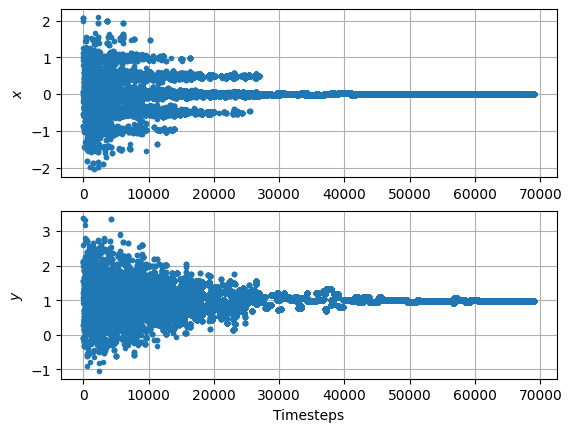

In [29]:
plt.figure(3)
plt.subplot(2, 1, 1)
plt.plot(x, ".")
plt.grid()
plt.ylabel("$x$")

plt.subplot(2, 1, 2)
plt.plot(y, ".")
plt.xlabel("Timesteps")
plt.ylabel("$y$")
plt.grid()

### More Complicated Example

Now try
$$f(x,y) = \cos x + \cos(\sqrt{2} x) + \cos(\sqrt{3}x) + (y-1)^2 $$ 

in the range $0<x<50$, $-20<y<20$ (this means we should reject $(x, y)$ values outside these ranges.)

There are 3 competing minima, all with $y=1:~x \approx 2,~16,~42$

In [30]:
def f(x_, y_):
    """The function to find the global minimum of"""
    return np.cos(x_) + np.cos(2**0.5 * x_) + np.cos(3**0.5 * x_) + (y_ - 1) ** 2

In [31]:
# params and initial values
tau = 20000
Tstart = 5.0
Xstart = 43.0
Ystart = 2.0
Tfinal = 0.0001

In [32]:
# this cell copied from previous section

x, y = [], []  # positions
x.append(Xstart)
y.append(Ystart)
T = Tstart  # temperature
time = 0

# while time < 100000:
while T > Tfinal:
    time += 1
    T = getTemp(Tstart, tau, time)
    dx, dy = draw_normal(1.0)
    xnew, ynew = x[-1] + dx, y[-1] + dy
    if xnew <= 0 or xnew >= 50 or ynew <= -20 or ynew >= 20:  # new code for boundaries
        # reject
        x.append(x[-1])
        y.append(y[-1])
    else:
        if decide(f(xnew, ynew), f(x[-1], y[-1]), T):
            # accept
            x.append(xnew)
            y.append(ynew)
        else:
            # reject
            x.append(x[-1])
            y.append(y[-1])


print(
    "The global minimum is estimated to be at (x, y) = ({0}, {1})".format(x[-1], y[-1])
)
print("    f({0:.2f}, {1:.2f}) = {2:.2f}".format(x[-1], y[-1], f(x[-1], y[-1])))

The global minimum is estimated to be at (x, y) = (41.7383010120238, 1.0242853901779658)
    f(41.74, 1.02) = -2.41


### SciPy Implementation

SciPy can do Simulated Annealing (https://en.wikipedia.org/wiki/Simulated_annealing) via the dual_annealing() function (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.dual_annealing.html).

It returns an OptimizeResult object (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html) that summarizes the success or failure of the search and the details of the solution if found.

See how much faster it runs, because of various memory-management tricks it uses...

In [33]:
from scipy.optimize import dual_annealing


# The function to minimize must take one argument, which is a vector. in this case, represents [x,y]
def fForSciPy(v):
    x_ = v[0]
    y_ = v[1]
    return f(x_, y_)


# The bounds must be defined in an array of 2-component vectors: [[x_min, x_max], [y_min, y_max]]
bounds = [[0.0, 50.0], [-20.0, 20.0]]

# perform the simulated annealing search
result = dual_annealing(fForSciPy, bounds)

# summarize the result
print("Status : %s" % result["message"])
print("Total Evaluations: %d" % result["nfev"])
# evaluate solution
solution = result["x"]
evaluation = fForSciPy(solution)
print("Solution: f(%s) = %.5f" % (solution, evaluation))

Status : ['Maximum number of iteration reached']
Total Evaluations: 4061
Solution: f([15.95950767  1.00000032]) = -2.61259


## Other Optimization Methods: available in SciPy

Basin-hopping: https://en.wikipedia.org/wiki/Basin-hopping , https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html

Differential Evolution: https://en.wikipedia.org/wiki/Differential_evolution , https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html

Specifically for sequence optimization: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.shgo.html 

Specifically for grid search optimization: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html 